In [1]:
import scanpy as sc
import scvi 
import anndata
import matplotlib.pyplot as plt
import numpy as np 
import torch
import pandas as pd
import seaborn as sb
import scanpy.external as sce
from tqdm import tqdm

torch.cuda.is_available() 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
scvi.settings.seed = 0

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
scvi.__version__

Global seed set to 0
/opt/conda/envs/SCVI-env/lib/python3.9/site-packages/flax/struct.py:133: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/conda/envs/SCVI-env/lib/python3.9/site-packages/flax/struct.py:133: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/conda/envs/SCVI-env/lib/python3.9/site-packages/flax/struct.py:133: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
Global seed set to 0


'0.20.1'

In [6]:
from platform import python_version
print(python_version()) 

3.9.16


In [3]:
adata_Endo = anndata.read_h5ad('adata_Endo.h5ad')

In [11]:
adata_Endo

AnnData object with n_obs × n_vars = 2173 × 28885
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'fig1b_annotation_20220202', 'joint_annotation_20220202', 'fig1b_annotation_v2', 'independent_annotation_refined_20220202'
    

In [7]:
np.unique(adata_Endo.obs.joint_annotation_20220202) 

array(['Arterioles', 'Capillaries', 'Capillary arterioles', 'Early LE',
       'Early endothelial cells', 'LE', 'Postcapillary venules',
       'Venules'], dtype=object)

In [9]:
adata_sub = adata_Endo[[c not in ['Lymphatic endothelium', 'Lymphatic endothelium','Early LE','LE'] for c in adata_Endo.obs.joint_annotation_20220202] ] 
adata = adata_sub.copy()
# removing F19 outlying cells
adata = adata[~np.logical_and(adata.obs.joint_annotation_20220202 == 'Arterioles', adata.obs.donor == 'F61')]

batch = [] 
for i in range(adata.shape[0]):
    #batch.append(adata.obs.chemistry_sorting[i] )#+ "_" + adata.obs.cell_caller[i]) 
    #batch.append(adata.obs.chemistry_sorting[i] ) 
   # batch.append(adata.obs.chemistry_sorting[i]  +  "_" + adata.obs.donor[i] + "_" + adata.obs.cell_caller[i]  ) # PREFERRED FOR NOW
    batch.append(adata.obs.chemistry_sorting[i]  + "_" + adata.obs.gender[i]+  "_" + adata.obs.donor[i] + "_" + adata.obs.cell_caller[i]  )
    #batch.append(adata.obs.chemistry_sorting[i] +"_" + adata.obs.cell_caller[i])
    
adata.obs['batch'] = batch 

# remove cell cycle genes
cc_genes = pd.read_csv('regev_lab_cell_cycle_genes.txt', header=None ) # https://notebook.community/theislab/scanpy_usage/180209_cell_cycle/cell_cycle -- 97 CC GENES
cc_genes = np.asarray(cc_genes[0]) 
relevent_cc_genes = [] 
for cc_gene in cc_genes:
    if(cc_gene in adata.var_names):
        relevent_cc_genes.append(cc_gene)
adata = adata[:,np.setdiff1d(adata.var_names,relevent_cc_genes)] 

mito_genes = adata.var_names.str.startswith('MT-') # 13 mito genes presents
total_UMI_count_across_mito_genes = np.sum(adata.X[:, mito_genes],axis=1).A1
total_UMI_count_across_genes = np.sum(adata.X,axis=1).A1 
adata.obs['percent_total_mito_UMI']= np.nan_to_num(np.divide(total_UMI_count_across_mito_genes,total_UMI_count_across_genes))
#sb.distplot(adata.obs['percent_total_mito_UMI']) 

Q1,Q3 = np.percentile(adata.obs['percent_total_mito_UMI'],[25,75])
IQR = Q3-Q1
U = Q3 + (1.5*IQR)
#print(U*100)
adata = adata[adata.obs['percent_total_mito_UMI']<0.08] 
sc.pp.filter_genes(adata, min_cells=3)

def preprocess2(adata, SCVI_integration=True):
    sc.pp.normalize_per_cell(adata, 10000) 
    sc.pp.log1p(adata)
    sc.pp.pca(adata)
    
    if(SCVI_integration):
        adata.raw = adata  # keep full dimension safe
        sc.pp.highly_variable_genes(adata, subset=True)
        scvi.settings.seed = 0
        scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")
        vae = scvi.model.SCVI(adata, n_layers=2, n_latent=10) # gene_likelihood="nb"
        vae.train()
        adata.obsm["X_scVI"] = vae.get_latent_representation()
        sc.pp.neighbors(adata, use_rep="X_scVI", method='gauss')
    else:
        sc.external.pp.harmony_integrate(adata, 'batch') #pip install harmonypy
        sc.pp.neighbors(adata, use_rep="X_pca_harmony")
        
    sc.tl.umap(adata)
    #sc.tl.leiden(adata)
    return adata

adata = preprocess2(adata, SCVI_integration=True)

/tmp/ipykernel_29163/3383588813.py:14: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['batch'] = batch
/tmp/ipykernel_29163/3383588813.py:28: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['percent_total_mito_UMI']= np.nan_to_num(np.divide(total_UMI_count_across_mito_genes,total_UMI_count_across_genes))
/opt/conda/envs/SCVI-env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
Global seed set to 0
/opt/conda/envs/SCVI-env/lib/python3.9/site-packages/scvi/data/_utils.py:175: UserWarning: Category 4 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
H

Epoch 400/400: 100%|██████████| 400/400 [00:58<00:00,  6.69it/s, loss=1.62e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:58<00:00,  6.85it/s, loss=1.62e+03, v_num=1]


/opt/conda/envs/SCVI-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/envs/SCVI-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/envs/SCVI-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


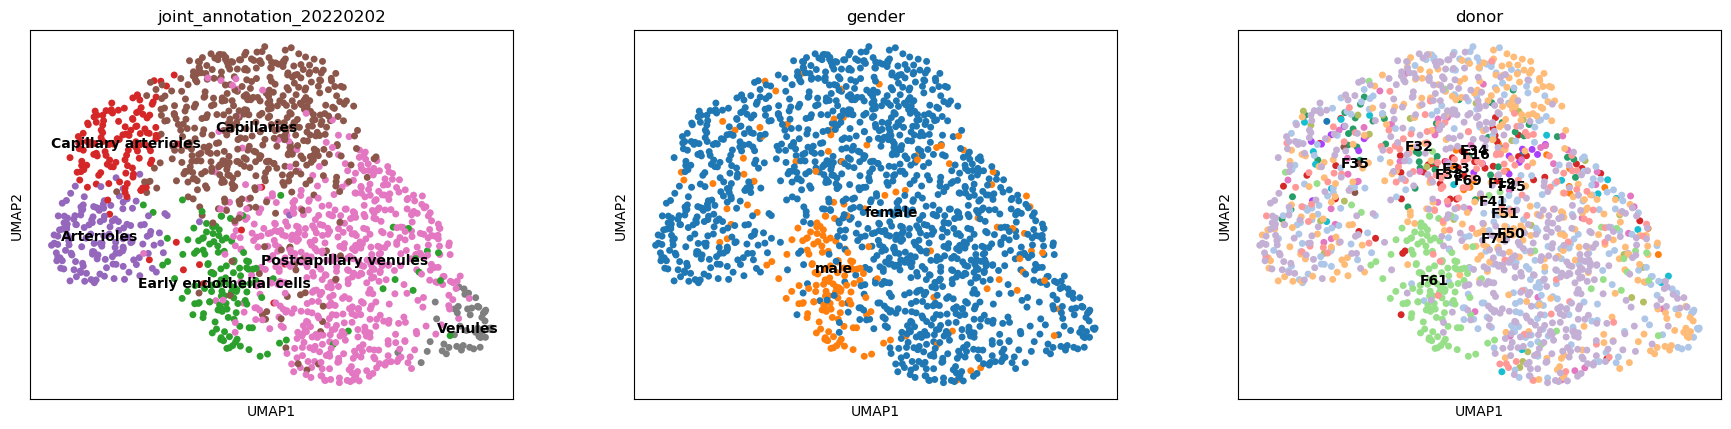

In [10]:
sc.pl.umap(adata, color=['joint_annotation_20220202','gender','donor'],s=100, legend_loc='on data')